In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
from urllib.request import urlretrieve
from itertools import islice
import torch
from torch import tensor
from random import random

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
!ls -l data

total 16656
-rw-rw-r-- 1 joey joey 17051982 Sep  6 17:48 mnist.pkl.gz


In [5]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [6]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [7]:
vals = list(range(1, 15))
vals

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [8]:
list(chunks(vals, 5))

[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14]]

In [9]:
chunked = chunks(vals, 5)

In [10]:
next(chunked)

[1, 2, 3, 4, 5]

In [11]:
img01 = x_train[0]

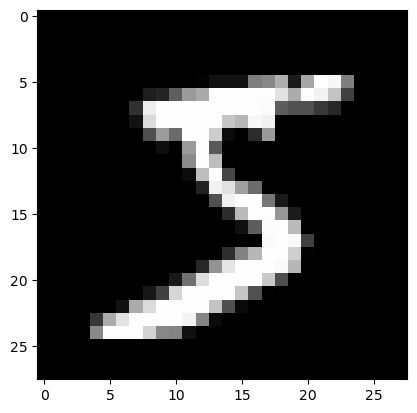

In [12]:
mpl.rcParams['image.cmap']='gray'
plt.imshow(list(chunks(img01, 28)))

In [13]:
it = iter(img01)
img = list(iter(lambda: list(islice(it, 28)), []))

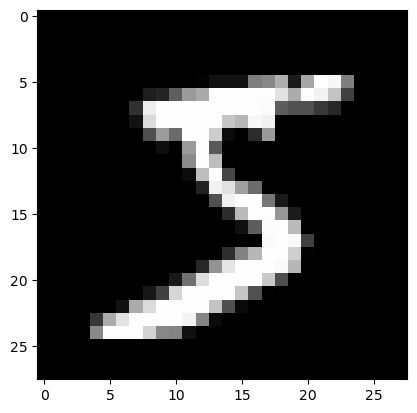

In [14]:
plt.imshow(img)

In [15]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [16]:
m = Matrix(img)
m[20,15]

0.98828125

In [17]:
tens = tensor(img)

In [18]:
tens[20,15]

tensor(0.9883)

In [19]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [20]:
x_train.type()

'torch.FloatTensor'

In [21]:
x_train.shape

torch.Size([50000, 784])

In [22]:
imgs = x_train.reshape([-1, 28, 28])

In [23]:
imgs.shape

torch.Size([50000, 28, 28])

In [24]:
imgs[0,20,15]

tensor(0.9883)

In [25]:
%timeit -n 10 list(chunks([random() for _ in range(7840)], 10))

234 µs ± 6.06 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit -n 10 torch.randn(784, 10)

20.7 µs ± 5.99 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So torch randn is definitely faster than using python random with our iter chunking method so we will use torch going forward.

## Matrix Multiplication 

In [27]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [28]:
m1 = x_valid[:5]  # Our first matrix is the first five images from our dataset
m2 = weights # The second matrix is the weights from our first nn layer

In [29]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [30]:
ar, ac = m1.shape
br, bc = m2.shape
ar, ac, br, bc # our shape info

(5, 784, 784, 10)

In [31]:
t1 = torch.zeros(ar, bc) #result matrix
t1.shape

torch.Size([5, 10])

In [32]:
for i in range(ar): # loop over 5 rows in first matrix
    for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
        for k in range(ac): # loop over the 784 values of the intersecting ac, br
            t1[i,j] += m1[i,k] * m2[k,j]

In [33]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [34]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [41]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    t1 = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
        for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
            for k in range(ac): # loop over the 784 values of the intersecting ac, br
                t1[i,j] += m1[i,k] * m2[k,j]
    return t1

In [42]:
%time _=matmul(m1, m2)

CPU times: user 253 ms, sys: 1.41 ms, total: 254 ms
Wall time: 254 ms


> This is a little slow...

In [43]:
from numba import njit
# this annotation will cause this function to be compiled to machine code the first time it is run
@njit
def dot(a,b): 
    res = 0.
    for i in range(len(a)): res+=a[i] * b[i]
    return res

In [44]:
from numpy import array

In [45]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 35 ms, sys: 3.46 ms, total: 38.5 ms
Wall time: 38 ms


20.0

In [46]:
%time dot(array([1.,2,3]), array([2.,3,4]))

CPU times: user 11 µs, sys: 7 µs, total: 18 µs
Wall time: 20.7 µs


20.0

time is way down after initial compile!

In [55]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    t1 = torch.zeros(ar, bc) #result matrix
    for i in range(ar): # loop over 5 rows in first matrix
        for j in range(bc): # loop over 10 columns in second matrix (here is defined the shape of our output)
            t1[i,j] = dot(a[i, :], b[:, j])
    return t1

In [56]:
from fastcore.test import *

In [57]:
m1a, m2a = m1.numpy(), m2.numpy()

In [60]:
test_close(t1, matmul(m1a, m2a))

In [61]:
%timeit -n 50 matmul(m1a, m2a)

143 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


> much faster!!!